In [50]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import random, math
import re
from scipy import stats
from collections import Counter
import time
import datetime
from operator import itemgetter
from sklearn import linear_model

def read_solutions(file):
    data = pd.read_csv(file, delimiter=';')
    # return data.values.tolist()
    return data

def get_string_data(data):
    return str(pd.to_datetime(data)).split()[0]

def get_day(string):
    return string.split()[0]

def get_time(string):
    return string.split()[1]

def get_string_time(string):
    return string.split()[1]

def get_integer_time(string):
    return int(string.split()[1].split(':')[0])*60 + int(string.split()[1].split(':')[1])

def get_day(data):
	return str(pd.to_datetime(data)).split()[0].split('-')[2]

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

Leitura dos dados

In [2]:
data_messages = read_solutions('DadosBrutosMessages_1.csv')
data_events = read_solutions('DadosBrutosEventTracks_3.csv')
user_dates = data_messages[data_messages['MessageOriginator'].str.lower() == 'user']['StorageDate'] 
bot_dates = data_messages[data_messages['MessageOriginator'].str.lower() == 'bot']['StorageDate'] 

Respondendo as perguntas:

Pergunta 1: Qual a quantidade de mensagens dos usuários? 

In [3]:
print('Quantidade de usuarios = ' + str(data_messages[data_messages['MessageOriginator'] == 'User'].shape[0]))

Quantidade de usuarios = 11022


Pergunta 2 - Quantos são os usuários únicos do Bot?

In [10]:
print('Usuários únicos do Bot = ' + str(data_messages[data_messages['MessageOriginator'] == 'Bot'].shape[0]))

Usuários únicos do Bot = 22744


Pergunta 3 - Qual a quantidade de mensagens trafegadas?

In [11]:
user_messages = data_messages[data_messages['MessageOriginator'] == 'User'].shape[0]
bot_messages = data_messages[data_messages['MessageOriginator'] == 'Bot'].shape[0]
total_messages = user_messages + bot_messages
print('Total de mensagens = ' + str(total_messages))

Total de mensagens = 33766


Pergunta 4 - Apresente, da forma como achar melhor, as interações que os foliões tiveram com o Bot.

Text(0,0.5,'Número de Mensagens')

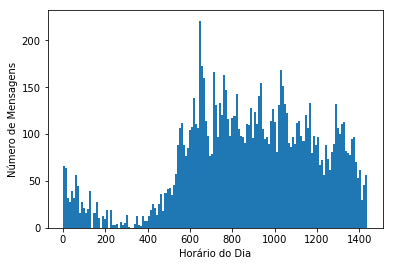

In [56]:
# Uma forma de ver como os usuários interagiram com o bot, é analisando os horários em que os usuários mais utilizaram o bot
# Para isso, será feito um histograma contando o número de mensagens por hora
# Uma pequena alteração nos dados será feita, o horário em que a mensagem foi enviada será convertido para minutos para podermos plotar os dados
# Assim, o dado não perderá o valor contido

histograma = plt.hist(user_dates.apply(get_integer_time), bins=150)
plt.xlabel('Horário do Dia')
plt.ylabel('Número de Mensagens')

/usr/local/lib/python3.4/dist-packages/numpy/core/fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


Text(0,0.5,'Hora do Dia (minutos corridos)')

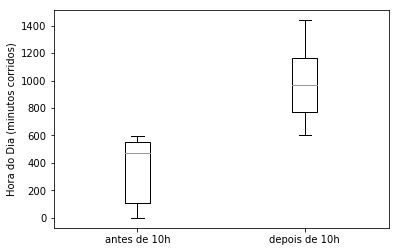

In [8]:
# Percebe-se uma diferença no número de mensagens enviadas entre os intervalos de 0h às 10h e 10h às 23h
# Algo que é esperado de ante-mão, uma vez que a programação do carnaval de BH é basicamente nesta faixa de horário
# Apenas para termos certeza, vamos fazer um boxplot para comparar
times = user_dates.apply(get_integer_time)
plt.boxplot( [times[times < 600], times[times > 600]])
plt.xticks([1, 2], ['antes de 10h','depois de 10h'])
plt.ylabel('Hora do Dia (minutos corridos)')

Como não há intercessão entre as duas caixas, podemos dizer que há diferença estatisticamente significante entre os horários


/usr/local/lib/python3.4/dist-packages/numpy/core/fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


Text(0,0.5,'Hora do Dia (minutos corridos)')

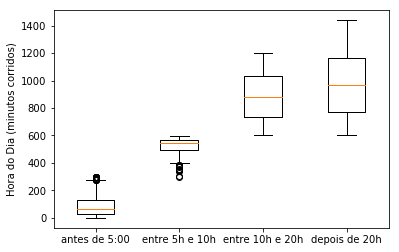

In [9]:
# Fazendo uma segunda análise, vamos dividir os dados em mais intervalos e fazer um boxplot
interval1 = times[times < 300] # t < 5h
interval2 = times[times[times > 300] & times[times < 600]] # 5h < t < 10h 
interval3 = times[times[times > 600] & times[times < 1200]] # 10h < t < 20h 
interval4 = times[times > 600] # 20h < t

plt.boxplot( [interval1, interval2, interval3, interval4])
plt.xticks([1, 2, 3, 4], ['antes de 5:00','entre 5h e 10h', 'entre 10h e 20h','depois de 20h'])
plt.ylabel('Hora do Dia (minutos corridos)')

Fica claro novamente que há diferença na utilização do bot entre os horários de 0h às 5h, 5h às 10h e 10h às 20h. Como aparentemente não há diferença na utilização de 10h até 23h59 é necessário aplicar um teste estatístico para se comparar estes valores.

Vale ressaltar que esta sendo feita apenas uma análise macro da utilização do bot. Para entendermos melhor sua utilização é necessário fazer um splot dos dados referentes a cada dia da semana, ver se há diferença entre os intervalos em um mesmo dia e entre cada dia.

Pergunta 5 - Quais botões foram os que tiveram maior interação?

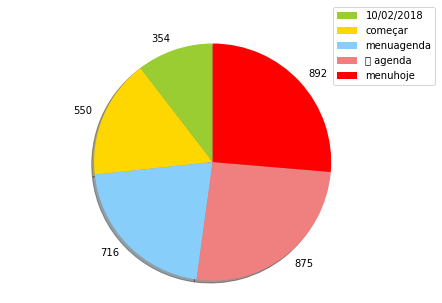

In [39]:
botoes = ['📅 Agenda','MenuAgenda','MenuHoje','Mais próximo','MenuEnviarLocal','MenuMeusBlocos','Blocos de Hoje','Começar','Dançar','Beber','Centro','eu vou','Como Chegar','Compartilhar c/geral 🎉','Compartilhar', '02/02/2018','03/02/2018','04/02/2018','05/02/2018','06/02/2018','07/02/2018','08/02/2018','09/02/2018','10/02/2018','11/02/2018','12/02/2018','13/02/2018']
utilizacao = {}
for botao in botoes:
    utilizacao[botao.lower()] = data_messages[data_messages['Message'].str.lower() == botao.lower()].shape[0]

utilizacao_ordenada = sorted(utilizacao.items(), key=itemgetter(1))
tamanho = len(utilizacao_ordenada)
numero_de_botoes = 5
utilizacao_ordenada = utilizacao_ordenada[tamanho-numero_de_botoes:tamanho]

valores = []
labels = []
for element in utilizacao_ordenada:
    valores.append(element[1])
    labels.append(element[0])
    
colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral', 'red']
patches, texts = plt.pie(np.array(valores)/sum(valores), labels=valores, colors=colors,shadow=True, startangle=90)
plt.legend(patches, labels, loc=[.8,.8])
plt.axis('equal')
plt.tight_layout()
plt.show()

Novas inferências

1 - Quais usuários mais utilizaram o bot?

In [40]:
pd.value_counts((data_messages['FromIdentity']))[1:11]

2132001316817479@messenger.gw.msging.net    550
1767958763279497@messenger.gw.msging.net    135
1775489765818948@messenger.gw.msging.net     81
1595484337207652@messenger.gw.msging.net     77
2111280855556324@messenger.gw.msging.net     76
1298966690205449@messenger.gw.msging.net     76
2289157887776255@messenger.gw.msging.net     67
1802284043179412@messenger.gw.msging.net     63
1680552578673715@messenger.gw.msging.net     63
1386097128167419@messenger.gw.msging.net     58
Name: FromIdentity, dtype: int64

2 - Quais dias do carnaval o bot foi mais utilizado? Como foi a utilização durante o mês?

Text(0,0.5,'Número de Mensagens')

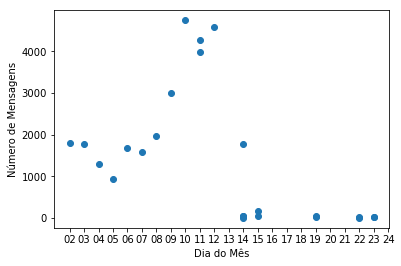

In [55]:
plt.scatter(data_messages['StorageDate'].apply(get_day).value_counts().index, data_messages['StorageDate'].apply(get_day).value_counts())
plt.xlabel('Dia do Mês')
plt.ylabel('Número de Mensagens')

3 - É possível descrever o comportamento da utilização do bot no intervalo de 10h até 23h por meio de um modelo de regressão linear?

Text(0,0.5,'Número de Mensagens')

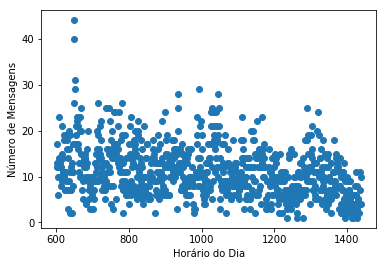

In [57]:
# para termos uma maior noção do que acontece com os dados, vamos fazer um scatterplot para ver a dispersão
data = pd.Series(times[times > 600].value_counts().index, times[times > 600].value_counts())
data.to_csv('data.csv') # salvando os dados para serem utilizados no R
plt.scatter(times[times > 600].value_counts().index, times[times > 600].value_counts())
plt.xlabel('Horário do Dia')
plt.ylabel('Número de Mensagens')


(669,) (2,)


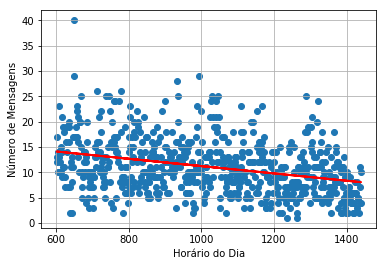

In [58]:
# Pelo R, foi calculado o coeficiente de correlação de Pearson = -0.3295969, Spearman = -0.3290413 e Kendall = -0.2302467
# são coeficientes de correlação que classificam uma relação fraca

# separando os dados de teste e treino
train_data = data.sample(frac=0.8, random_state=200)
test_data  = data.drop(train_data.index)
print(train_data.shape, test_data.shape)

# organizando os dados de treino do modelo
x_train = train_data.values.reshape(-1,1)
y_train = train_data.index.values.reshape(-1,1)

# fazendo o modelo
simple_model = linear_model.LinearRegression()
simple_model.fit(x_train, y_train)

# apresentando o modelo
plt.grid('on')
plt.scatter(x_train, y_train)
plt.plot(x_train, simple_model.predict(x_train), color='red', linewidth=2)
plt.xlabel('Horário do Dia')
plt.ylabel('Número de Mensagens')
plt.show()


In [54]:
# organizando os dados de teste
x_test = test_data.values.reshape(-1,1)
y_test = test_data.index.values.reshape(-1,1)
y_pred = simple_model.predict(x_test)

# avaliando o modelo com os dados de teste
print('intercept:', simple_model.intercept_, 'coefficients:', simple_model.coef_)
print("RMSE: %.2f" % (rmse(y_pred, y_test)))

intercept: [ 18.44918802] coefficients: [[-0.00723053]]
RMSE: 24.63


Hipóteses não validadas
a) o bot atendeu a necessidade do usuário - pensar em alguma forma de feedback ao fechar o bot
b) haveria como localizar de onde o usuário utilizou o bot? IP?
c) haveria diferença nos resultados obtidos ao se comparar cada dia do carnaval? (pensando numa análise micro dos dados)
d) seria possível fazer uma análise de sentimento da interação do usuário com o bot? (para entender o comportamento do usuário)
e) com base no comportamento do usuário, seria possível fazer alguma recomendação de evento?
f) como os coeficientes de correlação do modelo não mostraram uma forte correlação, uma alternativa seria em organizar os dados, dividindo por intervalos de tempo (por exemplo, de meia em meia hora) e refazer o modelo linear.